In [6]:
# -*- coding: utf-8 -*-

# importing utilities
import os
import sys
from datetime import datetime

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# importing pytorch libraries
import torch
from torch import nn
from torch import autograd
from torch.utils.data import DataLoader

# import visualization libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.display import Image, display
sns.set_style('darkgrid')

# ignore potential warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
USE_CUDA = True
# init deterministic seed
seed_value = 1234 #4444 #3333 #2222 #1111 #1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

# load the dataset into the notebook kernel
ori_dataset = pd.read_csv('/content/fraud_dataset_v2.csv')

# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT']

# encode categorical attributes into a binary one-hot encoded representation
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])


# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT']

# encode categorical attributes into a binary one-hot encoded representation
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

# select "DMBTR" vs. "WRBTR" attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-7
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)


In [7]:
# implementation of the encoder network
class encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()

        # specify layer 1 - in 618, out 512
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=512, bias=True) # add linearity
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights according to [9]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify layer 2 - in 512, out 256
        self.encoder_L2 = nn.Linear(512, 256, bias=True)
        nn.init.xavier_uniform_(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 256, out 128
        self.encoder_L3 = nn.Linear(256, 128, bias=True)
        nn.init.xavier_uniform_(self.encoder_L3.weight)
        self.encoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 128, out 64
        self.encoder_L4 = nn.Linear(128, 64, bias=True)
        nn.init.xavier_uniform_(self.encoder_L4.weight)
        self.encoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 64, out 32
        self.encoder_L5 = nn.Linear(64, 32, bias=True)
        nn.init.xavier_uniform_(self.encoder_L5.weight)
        self.encoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 32, out 16
        self.encoder_L6 = nn.Linear(32, 16, bias=True)
        nn.init.xavier_uniform_(self.encoder_L6.weight)
        self.encoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 7 - in 16, out 8
        self.encoder_L7 = nn.Linear(16, 8, bias=True)
        nn.init.xavier_uniform_(self.encoder_L7.weight)
        self.encoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 8, out 4
        self.encoder_L8 = nn.Linear(8, 4, bias=True)
        nn.init.xavier_uniform_(self.encoder_L8.weight)
        self.encoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 4, out 3
        self.encoder_L9 = nn.Linear(4, 3, bias=True)
        nn.init.xavier_uniform_(self.encoder_L9.weight)
        self.encoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)

    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.dropout(self.encoder_L1(x)))
        x = self.encoder_R2(self.dropout(self.encoder_L2(x)))
        x = self.encoder_R3(self.dropout(self.encoder_L3(x)))
        x = self.encoder_R4(self.dropout(self.encoder_L4(x)))
        x = self.encoder_R5(self.dropout(self.encoder_L5(x)))
        x = self.encoder_R6(self.dropout(self.encoder_L6(x)))
        x = self.encoder_R7(self.dropout(self.encoder_L7(x)))
        x = self.encoder_R8(self.dropout(self.encoder_L8(x)))
        x = self.encoder_R9(self.encoder_L9(x)) # don't apply dropout to the AE bottleneck

        return x

# init training network classes / architectures
encoder_train = encoder()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    encoder_train = encoder().cuda()


In [8]:
# implementation of the decoder network
class decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()

        # specify layer 1 - in 3, out 4
        self.decoder_L1 = nn.Linear(in_features=3, out_features=4, bias=True) # add linearity
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # init weights according to [9]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify layer 2 - in 4, out 8
        self.decoder_L2 = nn.Linear(4, 8, bias=True)
        nn.init.xavier_uniform_(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 8, out 16
        self.decoder_L3 = nn.Linear(8, 16, bias=True)
        nn.init.xavier_uniform_(self.decoder_L3.weight)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 16, out 32
        self.decoder_L4 = nn.Linear(16, 32, bias=True)
        nn.init.xavier_uniform_(self.decoder_L4.weight)
        self.decoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 32, out 64
        self.decoder_L5 = nn.Linear(32, 64, bias=True)
        nn.init.xavier_uniform_(self.decoder_L5.weight)
        self.decoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 64, out 128
        self.decoder_L6 = nn.Linear(64, 128, bias=True)
        nn.init.xavier_uniform_(self.decoder_L6.weight)
        self.decoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 7 - in 128, out 256
        self.decoder_L7 = nn.Linear(128, 256, bias=True)
        nn.init.xavier_uniform_(self.decoder_L7.weight)
        self.decoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 256, out 512
        self.decoder_L8 = nn.Linear(256, 512, bias=True)
        nn.init.xavier_uniform_(self.decoder_L8.weight)
        self.decoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 512, out 618
        self.decoder_L9 = nn.Linear(in_features=512, out_features=ori_subset_transformed.shape[1], bias=True)
        nn.init.xavier_uniform_(self.decoder_L9.weight)
        self.decoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)

    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.dropout(self.decoder_L1(x)))
        x = self.decoder_R2(self.dropout(self.decoder_L2(x)))
        x = self.decoder_R3(self.dropout(self.decoder_L3(x)))
        x = self.decoder_R4(self.dropout(self.decoder_L4(x)))
        x = self.decoder_R5(self.dropout(self.decoder_L5(x)))
        x = self.decoder_R6(self.dropout(self.decoder_L6(x)))
        x = self.decoder_R7(self.dropout(self.decoder_L7(x)))
        x = self.decoder_R8(self.dropout(self.decoder_L8(x)))
        x = self.decoder_R9(self.decoder_L9(x)) # don't apply dropout to the AE output

        return x

# init training network classes / architectures
decoder_train = decoder()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    decoder_train = decoder().cuda()


In [16]:
# define the optimization criterion / loss function
loss_function = nn.BCEWithLogitsLoss(reduction='mean')
# define learning rate and optimization strategy
#learning_rate = 1e-3
learning_rate = 1e-2
encoder_optimizer = torch.optim.Adam(encoder_train.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder_train.parameters(), lr=learning_rate)

# specify training parameters
#changed the number of epochs to 30
#num_epochs = 30
num_epochs = 5
mini_batch_size = 128

# convert pre-processed data to pytorch tensor
#torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()
torch_dataset = torch.from_numpy(ori_subset_transformed.astype(np.float32).values).float() # Convert all columns to float32

# convert to pytorch tensor - none cuda enabled
dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0)
# note: we set num_workers to zero to retrieve deterministic results

# determine if CUDA is available at compute node
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    dataloader = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=True)

[LOG 20250508-01:27:20] training status, epoch: [0001/0005], batch: 1000, loss: 0.0054, mode: GPU, time required: 0:00:05.269845
[LOG 20250508-01:27:25] training status, epoch: [0001/0005], batch: 2000, loss: 0.0065, mode: GPU, time required: 0:00:05.313309
[LOG 20250508-01:27:31] training status, epoch: [0001/0005], batch: 3000, loss: 0.0047, mode: GPU, time required: 0:00:05.353030
[LOG 20250508-01:27:36] training status, epoch: [0001/0005], batch: 4000, loss: 0.0057, mode: GPU, time required: 0:00:05.320560
[LOG 20250508-01:27:41] training status, epoch: [0001/0005], loss: 0.0154883740
[LOG 20250508-01:27:46] training status, epoch: [0002/0005], batch: 1000, loss: 0.0033, mode: GPU, time required: 0:00:05.309511
[LOG 20250508-01:27:51] training status, epoch: [0002/0005], batch: 2000, loss: 23.3762, mode: GPU, time required: 0:00:05.295793
[LOG 20250508-01:27:57] training status, epoch: [0002/0005], batch: 3000, loss: 3.9978, mode: GPU, time required: 0:00:05.245122
[LOG 20250508-01

Text(0.5, 1.0, 'AENN training performance')

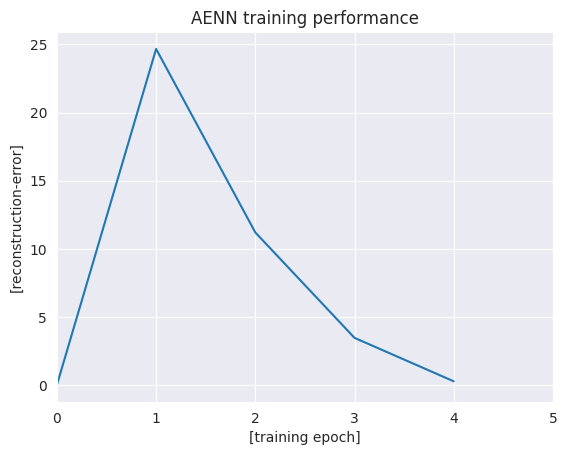

In [17]:
# init collection of mini-batch losses
losses = []

# convert encoded transactional data to torch Variable
data = autograd.Variable(torch_dataset)

# train autoencoder model
for epoch in range(num_epochs):

    # init mini batch counter
    mini_batch_count = 0

    # determine if CUDA is available at compute node
    if(torch.backends.cudnn.version() != None) and (USE_CUDA == True):

        # set networks / models in GPU mode
        encoder_train.cuda()
        decoder_train.cuda()

    # set networks in training mode (apply dropout when needed)
    encoder_train.train()
    decoder_train.train()

    # start timer
    start_time = datetime.now()

    # iterate over all mini-batches
    for mini_batch_data in dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # convert mini batch to torch variable
        mini_batch_torch = autograd.Variable(mini_batch_data)

        # =================== (1) forward pass ===================================

        # run forward pass
        z_representation = encoder_train(mini_batch_torch) # encode mini-batch data
        mini_batch_reconstruction = decoder_train(z_representation) # decode mini-batch data

        # =================== (2) compute reconstruction loss ====================

        # determine reconstruction loss
        reconstruction_loss = loss_function(mini_batch_reconstruction, mini_batch_torch)

        # =================== (3) backward pass ==================================

        # reset graph gradients
        decoder_optimizer.zero_grad()
        encoder_optimizer.zero_grad()

        # run backward pass
        reconstruction_loss.backward()

        # =================== (4) update model parameters ========================

        # update network parameters
        decoder_optimizer.step()
        encoder_optimizer.step()

        # =================== monitor training progress ==========================

        # print training progress each 1'000 mini-batches
        if mini_batch_count % 1000 == 0:

            # print the training mode: either on GPU or CPU
            mode = 'GPU' if (torch.backends.cudnn.version() != None) and (USE_CUDA == True) else 'CPU'

            # print mini batch reconstuction results
            now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            end_time = datetime.now() - start_time
            print('[LOG {}] training status, epoch: [{:04}/{:04}], batch: {:04}, loss: {}, mode: {}, time required: {}'.format(now, (epoch+1), num_epochs, mini_batch_count, np.round(reconstruction_loss.item(), 4), mode, end_time))

            # reset timer
            start_time = datetime.now()

    # =================== evaluate model performance =============================

    # set networks in evaluation mode (don't apply dropout)
    encoder_train.cpu().eval()
    decoder_train.cpu().eval()

    # reconstruct encoded transactional data
    reconstruction = decoder_train(encoder_train(data))

    # determine reconstruction loss - all transactions
    reconstruction_loss_all = loss_function(reconstruction, data)

    # collect reconstruction loss
    losses.extend([reconstruction_loss_all.item()])

    # print reconstuction loss results
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] training status, epoch: [{:04}/{:04}], loss: {:.10f}'.format(now, (epoch+1), num_epochs, reconstruction_loss_all.item()))

    # =================== save model snapshot to disk ============================

    # save trained encoder model file to disk
    encoder_model_name = "ep_{}_encoder_model.pth".format((epoch+1))
    torch.save(encoder_train.state_dict(), os.path.join("/content/models", encoder_model_name))

    # save trained decoder model file to disk
    decoder_model_name = "ep_{}_decoder_model.pth".format((epoch+1))
    torch.save(decoder_train.state_dict(), os.path.join("/content/models", decoder_model_name))

# plot the training progress
plt.plot(range(0, len(losses)), losses)
plt.xlabel('[training epoch]')
plt.xlim([0, len(losses)])
plt.ylabel('[reconstruction-error]')
#plt.ylim([0.0, 1.0])
plt.title('AENN training performance')



In [18]:
# restore pretrained model checkpoint
# encoder_model_name = "ep_10_encoder_model.pth"
# decoder_model_name = "ep_10_decoder_model.pth"
encoder_model_name = "ep_5_encoder_model.pth"
decoder_model_name = "ep_5_decoder_model.pth"

# init training network classes / architectures
encoder_eval = encoder()
decoder_eval = decoder()

# load trained models
encoder_eval.load_state_dict(torch.load(os.path.join("/content/models", encoder_model_name)))
decoder_eval.load_state_dict(torch.load(os.path.join("/content/models", decoder_model_name)))

<All keys matched successfully>

In [19]:
# convert encoded transactional data to torch Variable
data = autograd.Variable(torch_dataset)

# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# reconstruct encoded transactional data
reconstruction = decoder_eval(encoder_eval(data))

In [20]:
# determine reconstruction loss - all transactions
reconstruction_loss_all = loss_function(reconstruction, data)

# print reconstruction loss - all transactions
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] collected reconstruction loss of: {:06}/{:06} transactions'.format(now, reconstruction.size()[0], reconstruction.size()[0]))
print('[LOG {}] reconstruction loss: {:.10f}'.format(now, reconstruction_loss_all.item()))


[LOG 20250508-01:29:28] collected reconstruction loss of: 533009/533009 transactions
[LOG 20250508-01:29:28] reconstruction loss: 0.2812653482


In [21]:
# init binary cross entropy errors
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

# iterate over all detailed reconstructions
for i in range(0, reconstruction.size()[0]):

    # determine reconstruction loss - individual transactions
    reconstruction_loss_transaction[i] = loss_function(reconstruction[i], data[i]).item()

    if(i % 100000 == 0):

        ### print conversion summary
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] collected individual reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))

[LOG 20250508-01:29:28] collected individual reconstruction loss of: 000000/533009 transactions
[LOG 20250508-01:29:33] collected individual reconstruction loss of: 100000/533009 transactions
[LOG 20250508-01:29:39] collected individual reconstruction loss of: 200000/533009 transactions
[LOG 20250508-01:29:44] collected individual reconstruction loss of: 300000/533009 transactions
[LOG 20250508-01:29:50] collected individual reconstruction loss of: 400000/533009 transactions
[LOG 20250508-01:29:55] collected individual reconstruction loss of: 500000/533009 transactions


In [22]:
# init binary cross entropy errors
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

# iterate over all detailed reconstructions
for i in range(0, reconstruction.size()[0]):

    # determine reconstruction loss - individual transactions
    reconstruction_loss_transaction[i] = loss_function(reconstruction[i], data[i]).item()

    if(i % 100000 == 0):

        ### print conversion summary
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] collected individual reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))

[LOG 20250508-01:29:57] collected individual reconstruction loss of: 000000/533009 transactions
[LOG 20250508-01:30:03] collected individual reconstruction loss of: 100000/533009 transactions
[LOG 20250508-01:30:08] collected individual reconstruction loss of: 200000/533009 transactions
[LOG 20250508-01:30:14] collected individual reconstruction loss of: 300000/533009 transactions
[LOG 20250508-01:30:19] collected individual reconstruction loss of: 400000/533009 transactions
[LOG 20250508-01:30:25] collected individual reconstruction loss of: 500000/533009 transactions
